In [61]:
import torch
import pydicom
import pandas as pd
import numpy as np
import os
import pickle
import pydicom
import matplotlib.pyplot as plt

In [67]:
trainFile = "D:\\CBIS-DDSM\calc_case_description_test_set.csv"

pwd = os.getcwd()
os.chdir(os.path.dirname(trainFile))
trainData = pd.read_csv(os.path.basename(trainFile))
os.chdir("../")

trainData.dropna(inplace=True,how='all')
trainData['label'] = 0
trainData.loc[trainData['pathology'] == 'MALIGNANT','label'] = 1
pickle.dump(trainData,open(os.path.basename(trainFile)[:-4]+".pkl","wb"))

len(trainData)

284

In [69]:
trainData.head()

,patient_id,breast density,left or right breast,image view,abnormality id,abnormality type,calc type,calc distribution,assessment,pathology,subtlety,image file path,cropped image file path,ROI mask file path,label
0,P_00038,2.0,LEFT,CC,1.0,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4.0,BENIGN,2.0,CBIS-DDSM/Calc-Test_P_00038_LEFT_CC/08-29-2017...,CBIS-DDSM/Calc-Test_P_00038_LEFT_CC_1/08-29-20...,CBIS-DDSM/Calc-Test_P_00038_LEFT_CC_1/08-29-20...,0
1,P_00038,2.0,LEFT,MLO,1.0,calcification,PUNCTATE-PLEOMORPHIC,CLUSTERED,4.0,BENIGN,2.0,CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO/08-29-201...,CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO_1/08-29-2...,CBIS-DDSM/Calc-Test_P_00038_LEFT_MLO_1/08-29-2...,0
2,P_00038,2.0,RIGHT,CC,1.0,calcification,VASCULAR,NaN,2.0,BENIGN_WITHOUT_CALLBACK,5.0,CBIS-DDSM/Calc-Test_P_00038_RIGHT_CC/08-29-201...,CBIS-DDSM/Calc-Test_P_00038_RIGHT_CC_1/08-29-2...,CBIS-DDSM/Calc-Test_P_00038_RIGHT_CC_1/08-29-2...,0
3,P_00038,2.0,RIGHT,MLO,1.0,calcification,VASCULAR,NaN,2.0,BENIGN_WITHOUT_CALLBACK,5.0,CBIS-DDSM/Calc-Test_P_00038_RIGHT_MLO/08-29-20...,CBIS-DDSM/Calc-Test_P_00038_RIGHT_MLO_1/08-29-...,CBIS-DDSM/Calc-Test_P_00038_RIGHT_MLO_1/08-29-...,0
4,P_00041,1.0,LEFT,CC,2.0,calcification,LUCENT_CENTER,NaN,2.0,BENIGN_WITHOUT_CALLBACK,5.0,CBIS-DDSM/Calc-Test_P_00041_LEFT_CC/08-29-2017...,CBIS-DDSM/Calc-Test_P_00041_LEFT_CC_2/08-29-20...,CBIS-DDSM/Calc-Test_P_00041_LEFT_CC_2/08-29-20...,0


In [68]:
ds = pydicom.dcmread(trainData['image file path'].loc[0])
ds.pixel_array.shape

(4616, 3016)

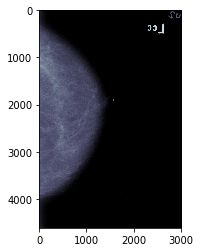

In [39]:

plt.imshow(ds.pixel_array, cmap=plt.cm.bone) 

In [15]:
from skimage import io, transform
from torch.utils.data import Dataset, DataLoader

class CBISDDSMDataset(Dataset):
    """Face Landmarks dataset."""

    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.CBISDDSM_frame = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.CBISDDSM_frame)

    def __getitem__(self, idx):
        img_name = os.path.join(self.root_dir,
                                self.CBISDDSM_frame['image file path'].loc[idx])
        ds = pydicom.dcmread(img_name)
        sample = ds.pixel_array
        if self.transform:
            sample = self.transform(sample)
        
        return torch.from_numpy(np.float64(sample)).cuda()

In [16]:
pwd = os.getcwd()
CBIS_Dataset = CBISDDSMDataset(trainFile,pwd)

In [17]:
CBIS_Dataset[0]

tensor([[38508., 38442., 38530.,  ...,     0.,     0.,     0.],
        [38244., 38596., 37627.,  ...,     0.,     0.,     0.],
        [39080., 39851., 39080.,  ...,     0.,     0.,     0.],
        ...,
        [25804., 22612., 20410.,  ...,     0.,     0.,     0.],
        [35668., 24990., 21819.,  ...,     0.,     0.,     0.],
        [61780., 40027., 24791.,  ...,     0.,     0.,     0.]],
       device='cuda:0', dtype=torch.float64)